In [1]:
%matplotlib inline

import os
import pickle
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import gym
import numpy as np
from collections import namedtuple
import random
from matplotlib import pyplot as pl
from PIL import Image
from IPython.display import clear_output
import torchvision.transforms as T

# Initialize environment

In [2]:
env = gym.make('Acrobot-v1')
eval_env = gym.make('Acrobot-v1')
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done', 'timeout'))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


# Hyper-parameters

In [3]:
# Task parameters.
output_size = env.action_space.n

# General parameters.
mem_capacity = 200000
batch = 128
lr = 2.5e-4
gamma = 0.99
num_steps = int(1e7)

# Double Q learning.
double_dqn = True

# How often, in steps, to update the target network.
target_update_freq = 500

# Number of random steps, to gather training data, before learning begins.
learn_start = 0 #10000

# Number of previous frames to stack in order to obtain a markovian representation.
hist_len = 4

# How often, in steps, to evaluate the network, and for how many episodes.
eval_freq = 10000
eval_episodes = 10

# Decay exploration coefficient linearly over eps_decay steps, down to the value of eps_end.
eps_decay = 1e6
eps_end = 0.2

# Success replay memory parameters
success_sample_probability_start = 0.5
success_sample_probability_decay = 1e6
success_sample_probability_end = 0.2
success_traj_length = 200

# Batch norm
batch_norm = True

use_cuda = torch.cuda.is_available()

# State helper function

In [4]:
def get_screen(_env, state):
    # Remove top 120 pixels from the image. This is whitespace which is never used / changed.
    screen = _env.render(mode='rgb_array')[120:, :, :].transpose(2,0,1)
    # Transform to grayscale, resize to 40x40.
    transform = T.Compose([T.ToPILImage(),
                           T.Grayscale(),
                           T.Resize((40, 40), interpolation=Image.CUBIC),
                           T.ToTensor()])
    # Normalize to [0, 1]
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)

    new_obs = transform(screen)
    if use_cuda:
        new_obs = new_obs.cuda()

    # Concat hist_len previous frames together.
    state = torch.cat([state[1:, :, :], 1 - new_obs], dim=0)
    return state

# Network definition

In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x


class DQN_CNN(nn.Module):
    def __init__(self, out_size, hist_len, batch_norm):
        super().__init__()        
        if batch_norm:
            self.sequential = nn.Sequential(
                nn.Conv2d(hist_len, 32, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                nn.Conv2d(32, 32, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.BatchNorm2d(32),
                Flatten(),
                nn.ReLU(),
                nn.Linear(128, out_size)
            )
        else:
            self.sequential = nn.Sequential(
                nn.Conv2d(hist_len, 32, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=5, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, kernel_size=5, stride=2),
                Flatten(),
                nn.ReLU(),
                nn.Linear(128, out_size)
            )

    def forward(self, x):
        return self.sequential(x)


# Better weight initialization than the standard one provided by PyTorch.
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)

In [7]:
class ReplayBuffer:
    def __init__(self, capacity, success_traj_length):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        
        # Success replay memory
        self.success_memory = []
        self.success_position = 0
        self.success_traj_length = success_traj_length
        self.success_capacity = int(0.25 * self.capacity)

    def add(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        
        # Once received done which isn't timeout - add trajectory to memory
        if self.memory[self.position].done and not self.memory[self.position].timeout:
            start_idx = self.position - 1
            while not self.memory[start_idx].done and start_idx > 0 and start_idx > self.position - success_traj_length:
                start_idx -= 1
            if self.memory[start_idx].done:
                start_idx += 1
        
            while start_idx <= self.position:
                if len(self.success_memory) < self.success_capacity:
                    self.success_memory.append(None)
                self.success_memory[self.success_position] = self.memory[start_idx]
                self.success_position = (self.success_position + 1) % self.success_capacity
                start_idx += 1
        
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, success_sample_prob):
        mem_size = len(self.memory)
        
        batch = []
        for _ in range(batch_size):
            # with probability success_prob, sample from successful trajectories
            if random.random() < success_sample_prob and len(self.success_memory) > 0:
                idx = random.randint(0, len(self.success_memory) - 1)
                batch.append(self.success_memory[idx])
            else:
                idx = random.randint(0, len(self.memory) - 1)
                # Do not sample transitions which are "done due to timeout". This is a non-markovian feature
                # which we would like to prevent the network from training on (it hurts convergence).
                while self.memory[idx].timeout:
                    idx = random.randint(0, len(self.memory) - 1)
                batch.append(self.memory[idx])

        batch_state, batch_action, batch_reward, batch_next_state, batch_done, _ = zip(*batch)
        return batch_state, batch_action, batch_reward, batch_next_state, batch_done

    def __len__(self):
        return len(self.memory)

# Initialize network, target, replaymemory and optimizer

In [8]:
network = DQN_CNN(output_size, hist_len, batch_norm)
network.apply(init_weights)
target_network = DQN_CNN(output_size, hist_len, batch_norm)
target_network.load_state_dict(network.state_dict())
memory = ReplayBuffer(mem_capacity, success_traj_length)

if use_cuda:
    network = network.cuda()
    target_network = target_network.cuda()
    
optimizer = optim.Adam(network.parameters(), lr=lr)

print number of model parameters

In [10]:
model_parameters = filter(lambda p: p.requires_grad, network.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

55075


In [ ]:
average_rewards = []
avg_rew_steps = []
successes = []
successes_steps = []
losses = []
losses_steps = []

# Training

In [ ]:
network.eval()
target_network.eval()
done = True
reward = -1
for step in trange(num_steps):
    if done:
        successes.append(done and reward >= 0)
        successes_steps.append(step)

        env.reset()
        state = torch.zeros((hist_len, 40, 40)).float()
        if use_cuda:
            state = state.cuda()
        state = get_screen(env, state)
    
    eps = max((eps_decay - step + learn_start) / eps_decay, eps_end)
    if random.random() < eps:  # take random action w.p. epsilon
        action = env.action_space.sample()
    else:
        action = network(state.unsqueeze(0)).max(1)[1].item()  # argmax_a Q(s_t, a)

    _, reward, done, _ = env.step(action)
    next_state = get_screen(env, state)
    
    memory.add(state, action, reward, next_state, not done, done and reward < 0)
    state = next_state
    
    if step >= learn_start:
        network.train()
        decay_coeff = (learn_start - step) * 1.0 / success_sample_probability_decay
        success_prob = max(success_sample_probability_start * decay_coeff + success_sample_probability_end * (1 - decay_coeff), success_sample_probability_end)
        batch_state, batch_action, batch_reward, batch_next_state, not_done_mask = memory.sample(batch, success_prob)
        
        batch_state = torch.stack(batch_state)
        batch_next_state = torch.stack(batch_next_state)
        batch_action = torch.tensor(batch_action, dtype=torch.int64).unsqueeze(-1)
        batch_reward = torch.tensor(batch_reward, dtype=torch.float32).unsqueeze(-1)
        not_done_mask = torch.tensor(not_done_mask, dtype=torch.float32).unsqueeze(-1)
        
        if use_cuda:
            batch_state = batch_state.cuda()
            batch_next_state = batch_next_state.cuda()
            batch_action = batch_action.cuda()
            batch_reward = batch_reward.cuda()
            not_done_mask = not_done_mask.cuda()
        
        current_Q = network(batch_state).gather(1, batch_action)
        
        with torch.no_grad():
            if double_dqn:
                # Get actions "a_t" from network
                next_state_actions = network(batch_next_state).max(1, keepdim=True)[1]
                # Get value "Q(s, a_t)" from target
                next_Q = target_network(batch_next_state).gather(1, next_state_actions)
            else:
                next_Q = target_network(batch_next_state).max(1, keepdim=True)[0]
            target_Q = batch_reward + (gamma * next_Q) * not_done_mask
            
        # Smooth L1 loss acts like L2 near the optimum, yet like L1 when far from it.
        # While the real objective is the L2, empirically this results in a more stable training regime
        # as the L1 is less sensitive to outliers.
        loss = F.smooth_l1_loss(current_Q, target_Q)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        losses_steps.append(step)
        network.eval()
    
        if step % target_update_freq == 0:
            target_network.load_state_dict(network.state_dict())
    
        if step % eval_freq == 0:
            total_reward = 0
            for eval_ep in range(eval_episodes):
                eval_env.reset()
                eval_state = torch.zeros((hist_len, 40, 40)).float()
                if use_cuda:
                    eval_state = eval_state.cuda()
                while True:
                    eval_state = get_screen(eval_env, eval_state)
                    action = network(eval_state.unsqueeze(0)).max(1)[1].item()
                    if random.random() < 0.01:
                        action = random.randrange(output_size)
                    _, eval_reward, done, _ = eval_env.step(action)
                    
                    total_reward += eval_reward
                    if done:
                        break
        
            average_reward = total_reward * 1.0 / eval_episodes
            average_rewards.append(average_reward)
            avg_rew_steps.append(step)
    
        if step % 1000 == 0:
            clear_output()
            pl.plot(losses_steps, losses)
            pl.title('Loss')
            pl.show()
            pl.plot(avg_rew_steps, average_rewards)
            pl.title('Reward')
            pl.show()
            pl.plot(successes_steps, successes)
            pl.title('Successes')
            pl.show()
        
            results = dict()
            results['average_rewards'] = average_rewards
            results['avg_rew_steps'] = avg_rew_steps
            results['successes'] = successes
            results['successes_steps'] = successes_steps
            results['losses'] = losses
            results['losses_steps'] = losses_steps

            with open(os.getcwd() + '/results' + ('_batch_norm' if batch_norm else ''), 'wb') as f:
                pickle.dump(results, f)

            torch.save(network.state_dict(), 'dqn' + ('_batch_norm' if batch_norm else ''))

results = dict()
results['average_rewards'] = average_rewards
results['avg_rew_steps'] = avg_rew_steps
results['successes'] = successes
results['successes_steps'] = successes_steps
results['losses'] = losses
results['losses_steps'] = losses_steps

with open(os.getcwd() + '/results' + ('_batch_norm' if batch_norm else ''), 'wb') as f:
    pickle.dump(results, f)

# Save network

In [9]:
# torch.save(network.state_dict(), 'dqn' + ('_batch_norm' if batch_norm else ''))

# Load network

In [16]:
network.load_state_dict(torch.load('dqn' + ('_batch_norm' if batch_norm else '')))

In [17]:
network.eval()

DQN_CNN(
  (sequential): Sequential(
    (0): Conv2d(4, 32, kernel_size=(5, 5), stride=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 32, kernel_size=(5, 5), stride=(2, 2))
    (7): ReLU()
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Flatten()
    (10): ReLU()
    (11): Linear(in_features=128, out_features=3, bias=True)
  )
)

# Evaluate network with mean and std outputs

In [38]:
rews = []
for _ in range(100):
    eval_env.reset()
    eval_state = torch.zeros((hist_len, 40, 40)).float()
    if use_cuda:
        eval_state = eval_state.cuda()
    rew = 0
    while True:
        eval_state = get_screen(eval_env, eval_state)

        q_vals = network(eval_state.unsqueeze(0))
        action = q_vals.max(1)[1].item()
        _, reward, done, _ = eval_env.step(action)

        rew += reward
        
        if done:
            break
    rews.append(rew)
print('Average reward: ' + str(np.mean(rews)))
print('STD: ' + str(np.std(rews)))

Average reward: -147.68
STD: 33.334030659372715


# Create video

In [18]:
import imageio
images = []

eval_env.reset()
eval_state = torch.zeros((hist_len, 40, 40)).float()
if use_cuda:
    eval_state = eval_state.cuda()
while True:
    eval_state = get_screen(eval_env, eval_state)

    images.append(eval_env.render(mode='rgb_array'))
    
    q_vals = network(eval_state.unsqueeze(0))
    action = q_vals.max(1)[1].item()
    _, reward, done, _ = eval_env.step(action)

    if done:
        break
imageio.mimsave('acrobot.gif', images)

# Load and plot graph data

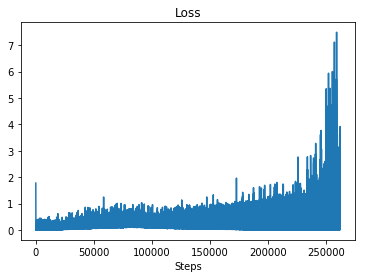

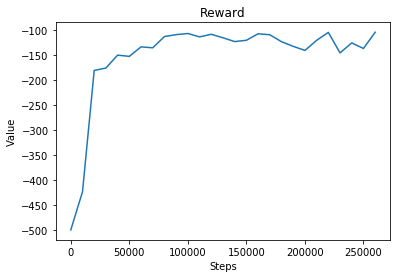

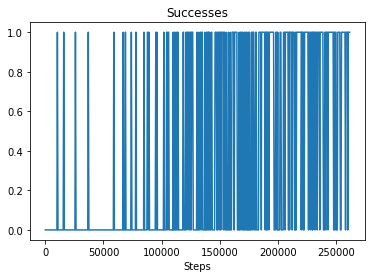

In [35]:
with open(os.getcwd() + '/results' + ('_batch_norm' if batch_norm else ''), 'rb') as f:
    results = pickle.load(f)
    
pl.plot(results['losses_steps'], results['losses'])
pl.title('Loss')
pl.xlabel('Steps')
pl.show()
pl.plot(results['avg_rew_steps'], results['average_rewards'])
pl.title('Reward')
pl.ylabel('Value')
pl.xlabel('Steps')
pl.show()
pl.plot(results['successes_steps'], results['successes'])
pl.title('Successes')
pl.xlabel('Steps')
pl.show()